In [1]:
import os
import sys

# path variables
root = os.path.join(os.getenv("REPO_ROOT"), "src")
%cd $root
sys.path.insert(0, root)

import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

# plotting
%matplotlib inline
sns.set_style("whitegrid")

from etl import get_latest_concatenated

/Users/stevenkim/src/github/nypdcd/src


# Data ingestion

**Note:** Some dates have clear entry errors:

* one report is from year 1018, which maybe was supposed to be "10/18";
* another report is timestamped for the year 2018, which was probably supposed to be "1981";
* there are other reports from 1912 and 1920, which are likely "2012" and "2020".
* some timestamps are impossible under daylight savings time (assuming NYC time zone).

In [2]:
ASIAN = "ASIAN / PACIFIC ISLANDER"
HORIZON = pd.Timedelta(13, "W")
BEGIN = "2017-01-01"  # want to keep this recent so as not to conflate with population changes
END = "2020-07-01"  # only Q2 data released so far


raw = (
    get_latest_concatenated()
    .assign(date=lambda x: pd.to_datetime(x.CMPLNT_FR_DT, format="%m/%d/%Y", errors="coerce"))
    .loc[lambda x: ~x.date.isnull()]
    .set_index("date")
    .sort_index()
    .loc[BEGIN: END]
)

# restrict to inter-race crimes
df = (
    raw
    .loc[(
        (raw.VIC_RACE != raw.SUSP_RACE)  
        & (raw.SUSP_RACE != "UNKNOWN")
        & (raw.SUSP_RACE != "OTHER")
    )]
)

# rearrange and aggregate
victim_race = (
    df
    .VIC_RACE
    .groupby(level=0)
    .apply(lambda x: x.value_counts())
    .unstack()
    .fillna(0)
    .resample("D")
    .sum()
    .assign(TOTAL=lambda x: x.sum(axis=1))
)

/Users/stevenkim/src/github/nypdcd/.venv/lib/python3.8/site-packages/pandas/core/reshape/concat.py:271: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  op = _Concatenator(
/Users/stevenkim/src/github/nypdcd/.venv/lib/python3.8/site-packages/pandas/core/reshape/concat.py:271: DtypeWarning: Columns (8,16,22) have mixed types.Specify dtype option on import or set low_memory=False.
  op = _Concatenator(


# Summary plot

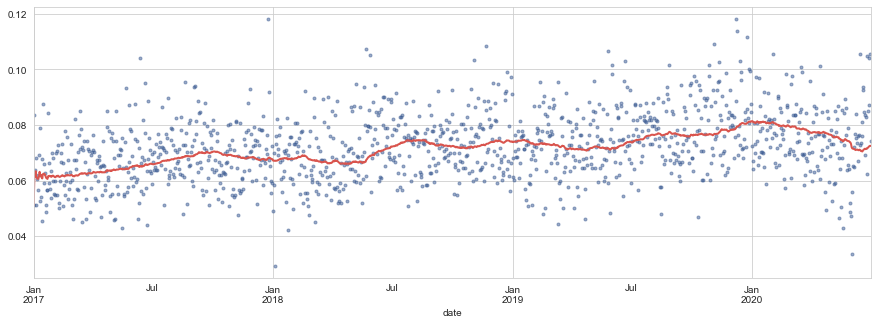

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
proportions_daily = victim_race[ASIAN] / victim_race["TOTAL"]
proportions_daily.plot(ax=ax, color=sns.xkcd_rgb["denim blue"], linestyle="", marker=".", alpha=0.5)
proportions_rolling = (
    victim_race[ASIAN].rolling(HORIZON).sum() 
    / victim_race["TOTAL"].rolling(HORIZON).sum()
)
proportions_rolling.plot(figsize=(15, 5), color=sns.xkcd_rgb["pale red"], linewidth=2)

# Two-sample test

In [4]:
CHANGEPOINT = "2020-01-01"


def binomial_two_sample_test(n1: int, p1: float, n2: int, p2: float, verbose: bool=False) -> float:
    """Given two samples from a Binomial distribution, test for equality of distributions."""
    q = (p1 * n1 + p2 * n2) / (n1 + n2)
    t = (p2 - p1) / (q * (1 - q) * ((1 / n1) + (1 / n2))) ** 0.5
    
    if verbose:
        print(f"Sample_1(n={n1:,}, p={p1 * 1e2:.2f}%)")
        print(f"Sample_2(n={n2:,}, p={p2 * 1e2:.2f}%)") 
        print(f"Overall probability {q * 1e2:.2f}%")
        print(f"test_statistic {t:.2f}")
    else:  
        return t

    
binomial_two_sample_test(
    n1=df.loc[:CHANGEPOINT].shape[0],
    p1=(df.loc[:CHANGEPOINT, "VIC_RACE"] == ASIAN).mean(),
    n2=df.loc[CHANGEPOINT:].shape[0],
    p2=(df.loc[CHANGEPOINT:, "VIC_RACE"] == ASIAN).mean(),
    verbose=True,
)

Sample_1(n=812,373, p=7.12%)
Sample_2(n=102,607, p=7.52%)
Overall probability 7.16%
test_statistic 4.66


# Fancy plot

In [15]:
fig = go.Figure(
    data=[
        go.Scatter(
            x=proportions_daily.index,
            y=proportions_daily.values * 1e2,
            mode='markers',
            opacity=0.75,
            marker=dict(
                size=3,
            ),
            marker_color=sns.xkcd_rgb["denim blue"],
            name="daily",
        ),
        go.Scatter(
            x=proportions_rolling.index,
            y=proportions_rolling.values * 1e2,
            mode='lines',
            opacity=1.0,
            line=dict(
                width=4.5,
            ),
            marker_color=sns.xkcd_rgb["pale red"],
            name=f"rolling {HORIZON.days // 7} weeks",
        ),
    ]
)
fig.update_layout(
    title="Percentage of NYC inter-racial crimes with A/PI victims",
    xaxis=dict(
        gridcolor="#eee",
    ),
    yaxis=dict(
        gridcolor="#eee",
        range=(0, 15),
        title="%",
    ),
    paper_bgcolor="rgba(0, 0, 0, 0)",
    plot_bgcolor="rgba(0, 0, 0, 0)",
    shapes=[dict(
        type='line',
        yref='paper', 
        y0=0, 
        y1=1,
        xref='x', 
        x0=pd.Timestamp(CHANGEPOINT), 
        x1=pd.Timestamp(CHANGEPOINT),
        line_color="#ddd",
        layer="below",
    )],
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.075,
        xanchor="center",
        x=0.5,
    ),
)
fig.show()

In [16]:
import plotly.io as pio
pio.write_html(fig, file="aa_plt.html", auto_open=True)